# k-NN, Linear Regression, Stochastic Gradient Descent

> By Sever Topan


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

%matplotlib inline

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

## 1.2 Euclidean Distance Function


### 1.2.1 

First we expand out the squared euclidean distance function.

$$
\begin{equation} \label{norm}
\begin{split}
\|x^{(m)} - x^* \|_2^2  & = \sum_{n=1}^N (x_n^{(m)} - x_n^*)^2 \\
& = \sum_{n=1}^N {x_n^{(m)}}^2 - 2x_n^*x_n^{(m)} + {x_n^*}^2 
\end{split}
\end{equation}
$$

In order to find the closest vetor $x^{(m)}$ to $x^*$, we need to search all $M$ vectors and minimize the value of the above expression. We now analyze each of the 3 terms in the expression individually.

1. $\sum_{n=1}^N {x_n^{(m)}}^2 = \|x^{(m)}\|_2^2$, which is the same over all  $x^{(m)}$ given the initial property.
2. $\sum_{n=1}^N - 2x_n^*x_n^{(m)} $ is different over all  $x^{(m)}$
3. $\sum_{n=1}^N {x_n^*}^2$ is again the same over all $x^{(m)}$

Out of the 3 terms, only the second must be evaluated in order to rank distances. We now observe that ranking $\sum_{n=1}^N - 2x_n^*x_n^{(m)} $ is equivalent to ranking $ - {x^{(m)}}^Tx^* $. Hence, in order to find the nearest neighbour of test point $x^*$, we must simply rank the negative inner product between the training and test data.





### 1.2.2

In [2]:
# initialize placeholders - x of shape BxN, z of shape CxN
x = tf.placeholder(tf.float32)
z = tf.placeholder(tf.float32)

# expand dimensions so that we can broadcast the matrices into dimension 3
x_exp = tf.expand_dims(x, -1)
z_exp = tf.expand_dims(z, -1)

# rotate the matrices so that subtraction will trigger correct broadcasting - x of shape 1xNxB
x_rotated = tf.transpose(x_exp, perm=[2, 1, 0])
subbed = (x_rotated - z_exp)

# perform subtraction, square, and sum reduction across dimension index 1 (that of size N)
sum_red_sq_sub = tf.reduce_sum(tf.square(subbed), 1)

# return transpose of the reduced matrix for output of the desired type BxC
pairwise_sq_euclid_dist = tf.transpose(sum_red_sq_sub)

In [3]:
# session run
sess.run(init)
sess.run(pairwise_sq_euclid_dist, feed_dict={x:np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), \
                                                z:np.array([[-1, 0, 0], [0, -1, 0], [0, 0, -1], [0, 0, 1]])})

array([[ 4.,  2.,  2.,  2.],
       [ 2.,  4.,  2.,  2.],
       [ 2.,  2.,  4.,  0.]], dtype=float32)

In [4]:
# session run
sess.run(init)
sess.run(pairwise_sq_euclid_dist, feed_dict={x:np.array([[4, 3], [0, 1], [7, 4]]), \
                                               z:np.array([[-1, 7], [4, -12], [12, 5], [6, 4]])})

array([[  41.,  225.,   68.,    5.],
       [  37.,  185.,  160.,   45.],
       [  73.,  265.,   26.,    1.]], dtype=float32)

## 1.3 Making Predictions

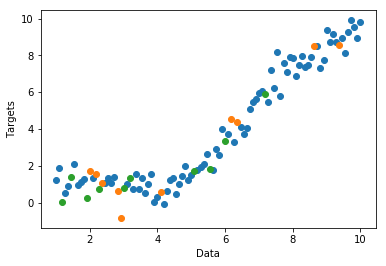

In [5]:
# generate test data
np.random.seed(521) 
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis] 
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) + 0.5 * np.random.randn(100 , 1)

randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

# display
plt.plot(trainData, trainTarget, 'o', validData, validTarget, 'o', testData, testTarget, 'o')
plt.xlabel('Data')
plt.ylabel('Targets')

### 1.3.1

In [6]:
# initialize placeholders
pairwise_dist = tf.placeholder(tf.float32)
k = tf.placeholder(tf.int32)

# obtain nearest neighbour indices
_, k_indices = tf.nn.top_k(-pairwise_dist, k)

# organize indices into a format recognized by sparse tensors
index_dims_untiled = tf.linspace(0., tf.cast(tf.shape(k_indices)[0], tf.float32) - 1., tf.shape(k_indices)[0])
index_dims_tiled = tf.expand_dims(tf.tile(tf.expand_dims(index_dims_untiled, -1), [1, k]), -1)
concat_indices = tf.concat(2, [index_dims_tiled, tf.cast(tf.expand_dims(k_indices, -1), tf.float32)])
reshaped_indices = tf.reshape(concat_indices, [tf.shape(k_indices)[0] * k, 2])

# create sparse tensor
valuesList = tf.fill([tf.shape(reshaped_indices)[0]], 1/k)
unordered_resp = tf.SparseTensor(tf.cast(reshaped_indices, tf.int64), values=valuesList, \
                                       shape=tf.cast(tf.shape(pairwise_dist), tf.int64))
ordered_resp = tf.sparse_reorder(unordered_resp)
calc_resp = tf.sparse_tensor_to_dense(ordered_resp)

In [7]:
sess.run(init)
trainData_pairwise_dist = sess.run(pairwise_sq_euclid_dist, feed_dict={x:trainData, z:trainData})
sess.run(calc_resp, feed_dict={pairwise_dist:trainData_pairwise_dist, k:5})

array([[ 0.2,  0. ,  0. , ...,  0. ,  0. ,  0.2],
       [ 0. ,  0.2,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.2, ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0.2,  0. ,  0. ],
       [ 0. ,  0.2,  0. , ...,  0. ,  0.2,  0. ],
       [ 0.2,  0. ,  0. , ...,  0. ,  0. ,  0.2]])

### 1.3.2

In [8]:
# placeholders
y_hat = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# loss function
y_diff = y_hat - y
M = tf.cast(tf.shape(y)[0], tf.float32)
calc_loss = 1. / (2. * M) * tf.matmul(tf.transpose(y_diff), y_diff)

In [9]:
# placeholders
resp = tf.placeholder(tf.float32)
y_prime = tf.placeholder(tf.float32)

# prediction function
calc_y_hat = tf.matmul(resp, y_prime)

In [10]:
# initialize responsibility matrices
sess.run(init)
trainData_pairwise_dist = sess.run(pairwise_sq_euclid_dist, feed_dict={x:trainData, z:trainData})
validData_pairwise_dist = sess.run(pairwise_sq_euclid_dist, feed_dict={x:validData, z:trainData})
testData_pairwise_dist = sess.run(pairwise_sq_euclid_dist, feed_dict={x:testData, z:trainData})

# initialize prediction varibles
prediction_y_hat = []
prediction_points = np.linspace(0., 11., num=1000)[:,np.newaxis]
prediction_pairwise_dist = sess.run(pairwise_sq_euclid_dist, \
                                    feed_dict={x:prediction_points, z:trainData})

# initialize k values, and loss lists
k_values = [1, 3, 5, 50]
train_loss, valid_loss, test_loss = [], [], []

for k_value in k_values:
    # training set
    train_resp = sess.run(calc_resp, feed_dict={pairwise_dist:trainData_pairwise_dist, k:k_value})
    y_hat_in = sess.run(calc_y_hat, feed_dict={resp:train_resp, y_prime:trainTarget})
    train_loss.append(sess.run(calc_loss, feed_dict={y_hat:y_hat_in, y:trainTarget})[0])
    
    # validation set
    valid_resp = sess.run(calc_resp, feed_dict={pairwise_dist:validData_pairwise_dist, k:k_value})
    y_hat_in = sess.run(calc_y_hat, feed_dict={resp:valid_resp, y_prime:trainTarget})
    valid_loss.append(sess.run(calc_loss, feed_dict={y_hat:y_hat_in, y:validTarget})[0])
    
    # test set
    test_resp = sess.run(calc_resp, feed_dict={pairwise_dist:testData_pairwise_dist, k:k_value})
    y_hat_in = sess.run(calc_y_hat, feed_dict={resp:test_resp, y_prime:trainTarget})
    test_loss.append(sess.run(calc_loss, feed_dict={y_hat:y_hat_in, y:testTarget})[0])
    
    # prediction
    prediction_resp = sess.run(calc_resp, feed_dict={pairwise_dist:prediction_pairwise_dist, k:k_value})
    prediction_y_hat.append(sess.run(calc_y_hat, feed_dict={resp:prediction_resp, y_prime:trainTarget}))   

In [11]:
# print table 
pd.DataFrame({'train loss':train_loss, \
              'validation loss':valid_loss, \
              'test loss':test_loss}, index=k_values)

,test loss,train loss,validation loss
1,[0.311004],[0.0],[0.27155]
3,[0.145092],[0.105242],[0.326278]
5,[0.178327],[0.118541],[0.310439]
50,[0.706935],[1.24801],[1.2287]


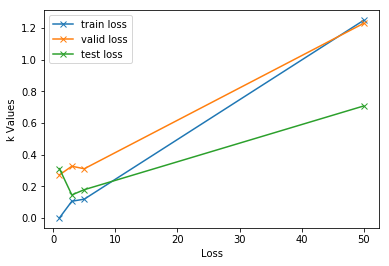

In [12]:
# plot 
plt.plot(k_values, train_loss, '-x', label='train loss')
plt.plot(k_values, valid_loss, '-x', label='valid loss')
plt.plot(k_values, test_loss, '-x', label='test loss')
plt.legend()
plt.xlabel('Loss')
plt.ylabel('k Values')

Out of the given $k$ values of $\{1, 3, 5, 50\}$, the value $5$ results in the lowest validation loss, hence we would be inclined to choose it as the optimal value. However, we can notice that the value $3$ results in the lowest overall test loss. 

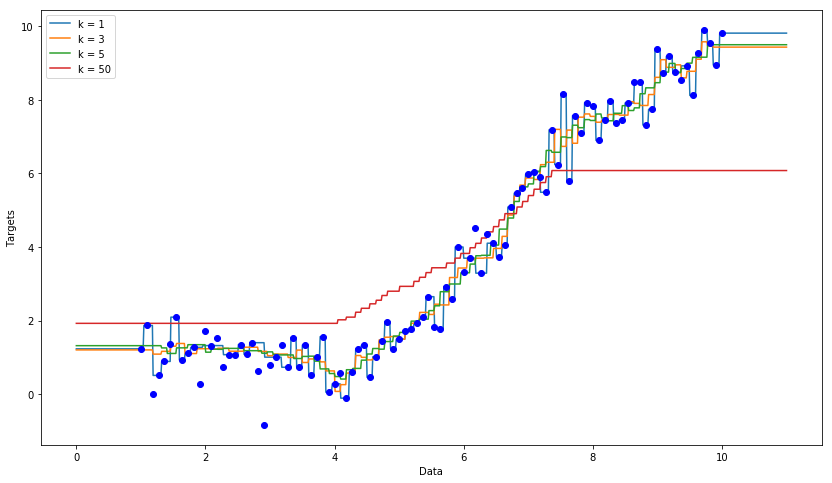

In [13]:
# plot predictions
plt.figure(figsize=(14, 8))

for i in range(len(k_values)):
    plt.plot(prediction_points, prediction_y_hat[i], label='k = ' + str(k_values[i]))
    
plt.plot(trainData, trainTarget, 'bo', validData, validTarget, 'bo', testData, testTarget, 'bo')

plt.legend()
plt.xlabel('Data')
plt.ylabel('Targets')

The prediction analysis follows:

- $k = 1$: We notice massive fluctuations in the predictions that match the test data set. This would not be a good prediction since it overfits the test data.
- $k = 3$: Takes a close local average. This is a relatively good prediction.
- $k = 5$: Takes a sligtly looser local average. This is a relatively good prediction.
- $k = 50$: Takes a large average that approximates the overall trend in the data points, but it doesn't approximate the data itself well.

Out of the listed predictions, $k = 3$ and $k = 5$ seem to approximate the data trend most accurately. They strike a balance between putting too much emphasis on local changes or global trends. The loss functions computed above also show this.

Though $k = 5$ resulted in the lowest loss out of the four listed $k$ values, if we sample more $k$ options we observe the global validation set loss minimum occurs at around $k = 19$. The code demonstrating this is below.

In [14]:
k_values = [2 * i + 1 for i in range(25)]
train_loss, valid_loss, test_loss = [], [], []

for k_value in k_values:
    # training data
    train_resp = sess.run(calc_resp, feed_dict={pairwise_dist:trainData_pairwise_dist, k:k_value})
    y_hat_in = sess.run(calc_y_hat, feed_dict={resp:train_resp, y_prime:trainTarget})
    train_loss.append(sess.run(calc_loss, feed_dict={y_hat:y_hat_in, y:trainTarget})[0])
    
    # validation data
    valid_resp = sess.run(calc_resp, feed_dict={pairwise_dist:validData_pairwise_dist, k:k_value})
    y_hat_in = sess.run(calc_y_hat, feed_dict={resp:valid_resp, y_prime:trainTarget})
    valid_loss.append(sess.run(calc_loss, feed_dict={y_hat:y_hat_in, y:validTarget})[0])
    
    # test data
    test_resp = sess.run(calc_resp, feed_dict={pairwise_dist:testData_pairwise_dist, k:k_value})
    y_hat_in = sess.run(calc_y_hat, feed_dict={resp:test_resp, y_prime:trainTarget})
    test_loss.append(sess.run(calc_loss, feed_dict={y_hat:y_hat_in, y:testTarget})[0])

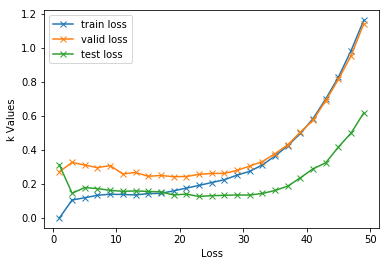

In [15]:
# plot
plt.plot(k_values, train_loss, '-x', label='train loss')
plt.plot(k_values, valid_loss, '-x', label='valid loss')
plt.plot(k_values, test_loss, '-x', label='test loss')
plt.legend()
plt.xlabel('Loss')
plt.ylabel('k Values')

## 2.1 Geometry of Linear Regression

### 2.1.1

We will prove the function is convex with respect to the weights and bias by proving the inequality for the individual $\mathcal{L}_D$ and $\mathcal{L}_W$ portions of the loss functions. First some notation and substitutions used in the derivations:

- We will denote $(1-\alpha)$ as $\beta$.
- $\alpha + \beta = 1$
- $\beta^2 = 1 - 2 \alpha + \alpha^2$.
- We will denote  $b - y^{(m)}$ as $\mathcal{Y}_b$ and $b - y_n^{(m)}$ as $\mathcal{Y}_{bn}$, this being present in the weight proofs
- We will denote $W^T x^{(m)} - y^{(m)}$ as $\Delta_{\hat{y}, y}$ and $W^T x^{(m)} - y_n^{(m)} $ as $\Delta_{(\hat{y}, y)n} $, this being present in the bias proof


We prove the jensen inequality for $\mathcal{L}_W$ with respect to weights:

$$
\begin{equation}
\begin{split}
\frac{\lambda}{2} \| \alpha W_1 + \beta W_2 \|_2^2 & \leq \frac{\lambda}{2} \big(\alpha \| W_1 \|_2^2 + \beta \| W_2 \|_2^2 \big) \\
\sum_n ( \alpha W_{1n} + \beta W_{2n} )^2 & \leq \sum_n \alpha W_{1n}^2 + \beta W_{2n}^2 \\
\alpha^2 W_{1n}^2 + 2 \alpha \beta W_{1n} W_{2n} + \beta^2 W_{2n}^2 & \leq \alpha W_{1n}^2 + \beta W_{2n}^2 \\
(\alpha^2 - \alpha) W_{1n}^2 + 2(\alpha - \alpha^2) W_{1n} W_{2n} + (1 - 2 \alpha + \alpha^2 - (1 - \alpha)) W_{2n}^2 & \leq 0 \\
(\alpha^2 - \alpha)( W_{1n}^2 - 2 W_{1n} W_{2n} + W_{2n}^2 ) & \leq 0 \\
(\alpha^2 - \alpha)( W_{1n} - W_{2n} )^2 & \leq 0
\end{split}
\end{equation}
$$

We notice that $ \alpha^2 - \alpha $ will always be less than or equal to zero since $ \alpha \in [0, 1] $ and that $( W_{1n} - W_{2n} )^2$ will always be greater than or equal to zero since our weights are not complex numbers. Hence the left hand side of the equation evaulates to either zero or a negative number, and the inequality is satisfied. 

We will now prove the jensen inequality for $\mathcal{L}_D$ with respect to weights:

$$
\begin{equation}
\begin{split}
\sum_m \frac{1}{2M} \| (\alpha W_1 + \beta W_2)^T x^{(m)} + \mathcal{Y}_{b} \|_2^2 & \leq \sum_m  \frac{1}{2M} \big( \alpha \| W_1^T x^{(m)} + \mathcal{Y}_{b} \|_2^2 + \beta \| W_2^T x^{(m)} + \mathcal{Y}_{b} \|_2^2 \big) \\
\sum_n \big( (\alpha W_1 + \beta W_2)^T x^{(m)} + \mathcal{Y}_{bn} \big)^2 & \leq \sum_n \alpha \big( W_1^T x^{(m)} + \mathcal{Y}_{bn} \big)^2 + \beta \big( W_2^T x^{(m)} + \mathcal{Y}_{bn} \big)^2 \\
\big( (\alpha W_1 + \beta W_2)^{T} x^{(m)} \big)^2 + 2(\alpha W_1 + \beta W_2)^{T} x^{(m)} \mathcal{Y}_{bn} + \mathcal{Y}_{bn}^2 & \leq \alpha \big( ( W_1^T x^{(m)} )^2 + 2 W_1^T x^{(m)}\mathcal{Y}_{bn} + \mathcal{Y}_{bn}^2 \big) +  \beta \big( ( W_2^T x^{(m)} )^2 + 2 W_2^T x^{(m)}\mathcal{Y}_{bn} + \mathcal{Y}_{bn}^2 \big) \\
\alpha^2 ( W_1^T )^2 (x^{(m)})^2 + 2 \alpha \beta W_1^T W_2^T (x^{(m)})^2 + \beta^2 ( W_2^T )^2 (x^{(m)})^2 + 2(\alpha W_1^T + \beta W_2^T) x^{(m)} \mathcal{Y}_{bn} + \mathcal{Y}_{bn}^2 & \leq  \alpha ( W_1^T )^2 (x^{(m)})^2 + \beta ( W_2^T )^2 (x^{(m)})^2 + 2(\alpha W_1 + \beta W_2)^{T} x^{(m)} \mathcal{Y}_{bn} + (\alpha + \beta) \mathcal{Y}_{bn}^2 \\
\alpha^2 ( W_1^T )^2 (x^{(m)})^2 + 2 \alpha \beta W_1^T W_2^T (x^{(m)})^2 + \beta^2 ( W_2^T )^2 (x^{(m)})^2 & \leq  \alpha ( W_1^T )^2 (x^{(m)})^2 + \beta ( W_2^T )^2 (x^{(m)})^2 \\
\alpha^2 ( W_1^T )^2 + 2 \alpha \beta W_1^T W_2^T + \beta^2 ( W_2^T )^2 & \leq  \alpha ( W_1^T )^2 + \beta ( W_2^T )^2 \\
(\alpha^2 - \alpha) ( W_1^T )^2 + 2 (\alpha - \alpha^2) W_1^T W_2^T + (1 - 2 \alpha + \alpha^2 - (1 - \alpha)) ( W_2^T )^2  & \leq  0 \\
(\alpha^2 - \alpha) \big( ( W_1^T )^2 - 2 W_1^T W_2^T + ( W_2^T )^2 \big) & \leq  0 \\
(\alpha^2 - \alpha)( W_1^T - W_2^T )^2 &\leq  0
\end{split}
\end{equation}
$$

Just like in the above, $ \alpha^2 - \alpha \leq 0 $ and $( W_1^T - W_2^T )^2 \geq 0$, hence the inequality is satisfied.

We will now prove the jensen inequality for the loss function with respect to bias. note that we do not have to solve for $\mathcal{L}_W$ since the bias is not present within the term.

$$
\begin{equation}
\begin{split}
\sum_m \frac{1}{2M} \| \alpha b_1 + \beta b_2 + \Delta_{\hat{y}, y} \|_2^2 & \leq \sum_m  \frac{1}{2M} \big( \alpha \| b_1 + \Delta_{\hat{y}, y} \|_2^2 + \beta \| b_2 + \Delta_{\hat{y}, y} \|_2^2 \big) \\
\sum_n ( \alpha b_1 + \beta b_2 + \Delta_{(\hat{y}, y)n} )^2 & \leq \sum_n \alpha ( b_1 + \Delta_{(\hat{y}, y)n} )^2 + \beta ( b_2 + \Delta_{(\hat{y}, y)n} )^2 \\
\alpha^2 b_1^2 + 2 \alpha \beta b_1 b_2 + \beta^2 b_2^2 + 2 \alpha b_1 \Delta_{(\hat{y}, y)n} + 2 \beta b_2 \Delta_{(\hat{y}, y)n}  + \Delta_{(\hat{y}, y)n}^2 & \leq \alpha b_1^2 + 2 \alpha b_1 \Delta_{(\hat{y}, y)n} + \alpha \Delta_{(\hat{y}, y)n}^2 + \beta b_2^2 + 2 \beta b_2 \Delta_{(\hat{y}, y)n} + \beta \Delta_{(\hat{y}, y)n}^2 \\
\alpha^2 b_1^2 + 2 \alpha \beta b_1 b_2 + \beta^2 b_2^2 + 2 & \leq \alpha b_1^2 + \beta b_2^2 \\
(\alpha^2 - \alpha) b_1^2 + 2(\alpha - \alpha^2) b_1 b_2 + (1 - 2 \alpha + \alpha^2 - (1 - \alpha)) b_2^2 & \leq 0 \\
(\alpha^2 - \alpha)( b_1^2 - 2 b_1 b_2 + b_2^2 ) & \leq 0 \\
(\alpha^2 - \alpha)( b_1 - b_2 )^2 & \leq 0
\end{split}
\end{equation}
$$

Again, as above, $ \alpha^2 - \alpha \leq 0 $ and $( b_1 - b_2 )^2 \geq 0$, hence the inequality is satisfied.


### 2.1.4

A multi-class classification task could be solved by discriminating between individual subsets of classes in each binary classification task. If we have the set of classes $\{ C_0, \dots C_D \} $ we could design a binary classifier to split the classes into subsets $\{ C_0, \dots C_k \} $ and $\{ C_{k+1}, \dots C_D \} $. We would then repeat the design procedure for each subset until we discriminate out the single classes.

## 2.2 Stochastic Gradient Descent

In [18]:
import numpy as np
with np.load ("tinymnist.npz") as data:
    trainData, trainTarget = data ["x"], data["y"]
    validData, validTarget = data ["x_valid"], data ["y_valid"]
    testData, testTarget = data ["x_test"], data ["y_test"]

Our linear regression model is defined below. It accepts 3 exit conditions:

1. `MAX_NUM_EPOCHS` is reached
2. An inputted `convergence_condition` is reached, or if the gradient descent diverges. This is used if we know the optimal overall loss that our regression model can achieve.
3. If no `convergence_condition` is inputted (i.e. a value of 0), the model can exit if the gradient difference between training steps is less than `GRADIENT_THRESHOLD`.

The way in which the exit conditions of the model will be used is that we will obtain a convergence condition by performing gradient descent on the full data model (batch size of 700) until the gradient becomes too shallow and either exit condition 1 or 3 is met. We will then use this exit condition to trigger exit condition 2 for subsequent regressions with the same loss function (i.e. the same $\lambda$ value).

In [19]:
def linear_regression_model_3(batch_size, λ, η, convergence_condition):
    # constants
    MAX_NUM_EPOCHS = 1000
    GRADIENT_THRESHOLD = 0.0001
    
    # return parameters
    num_gradient_descent_steps = 0

    # tf varibales - weights and bias
    W = tf.Variable(tf.zeros([64, 1]))
    b = tf.Variable(0.)

    # data/target placeholders for each iteration
    x = tf.placeholder(tf.float32, name='x')
    y = tf.placeholder(tf.float32, name='y')

    # y_hat output prediction function
    y_hat = tf.matmul(x, W) + b

    # mean squared loss with weight decay
    mse_weight_decay = 0.5 * tf.reduce_mean(tf.reduce_sum(tf.square(y_hat - y), reduction_indices=1)) \
                                + (λ / 2) * tf.reduce_sum(tf.square(W))

    # gradiend descent optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=η)
    train = optimizer.minimize(loss=mse_weight_decay)

    # variable initialization
    init = tf.global_variables_initializer()
    sess.run(init)
    sess.run([W, b])
    
    # init batch selection indices
    batch_selection_indices = np.linspace(0, trainData.shape[0] - 1, trainData.shape[0], dtype=np.int32)
    
    # MAX_NUM_EPOCHS represents exit condition 1
    convergence = False
    prev_loss = float('inf')
    for i in range(MAX_NUM_EPOCHS):
        # initialize batch selection variables
        np.random.seed(i)
        np.random.shuffle(batch_selection_indices)
        batch_start = 0
        batch_end = batch_size
        batching_complete = False
        
        # break when convergence occurs
        if convergence:
            break
        
        while not batching_complete:
            # obtain current batch
            batch_data = trainData[batch_selection_indices[batch_start:batch_end]]
            batch_target = trainTarget[batch_selection_indices[batch_start:batch_end]]
            
            # prepare for next batch
            batch_start += batch_size
            batch_end += batch_size
            batching_complete = batch_start == trainData.shape[0]
            num_gradient_descent_steps += 1
            
            # perform train step
            train_res, loss, curr_W, curr_b = sess.run([train, mse_weight_decay, W, b], \
                                                       feed_dict={x:batch_data, y:batch_target})

            # check overall loss after gradient descent step
            overall_loss = sess.run(mse_weight_decay, feed_dict={x:trainData, y:trainTarget})
            
            # exit condition 3
            if not convergence_condition and abs(prev_loss - overall_loss) < GRADIENT_THRESHOLD:
                convergence = True
                break
            
            # exit condition 2
            if overall_loss < convergence_condition \
                    or overall_loss == float('inf'):
                convergence = True
                if overall_loss == float('inf'):
                    num_gradient_descent_steps = float('inf')
                break
            else:
                prev_loss = overall_loss
                
    # obtain losses
    train_loss = sess.run(mse_weight_decay, feed_dict={x:trainData, y:trainTarget})
    valid_loss = sess.run(mse_weight_decay, feed_dict={x:validData, y:validTarget})
    test_loss = sess.run(mse_weight_decay, feed_dict={x:testData, y:testTarget})
    
    return num_gradient_descent_steps, train_loss, valid_loss, test_loss

### 2.2.1

In [20]:
# obtain convergence condition
convergence_condition = linear_regression_model_3(batch_size=700, λ=1, η=0.1, convergence_condition=0.0)[1]
convergence_condition

0.099237233

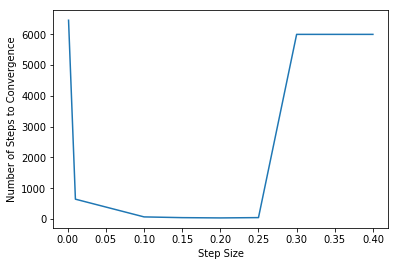

In [21]:
η_values = [0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.01, 0.001]
convergence_speed = []

# obtain convergence speed per η value
for η in η_values:
    num_steps = linear_regression_model_3(batch_size=50, λ=1, η=η, convergence_condition=convergence_condition)[0]
    
    # accomodate for graphing the value of inf
    if num_steps == float('inf'):
        num_steps = 6000
    
    # append to output list
    convergence_speed.append(num_steps)
    
plt.plot(η_values, convergence_speed)
plt.xlabel('Step Size')
plt.ylabel('Number of Steps to Convergence')

The step count of the gradient descent algorithm decreases exponentially with an increase in step size until around $\eta = 0.25$, past which it discontinues to infinity. The high learning rate at low $\eta$ values is caused by the slow rate at which the gradient is traversed. Learning rate increases with $\eta$ until $\eta$ is too large to be able to descend the convex loss surface, and our gradient descent diverges. The optimal learning rate occurs right before this discontinuity.

### 2.2.2

We will plot the different batch size performance versus different $\eta$ values in order to observe the effect of different minibatch sizes.

batch size  10  complete
batch size  50  complete
batch size  100  complete
batch size  700  complete


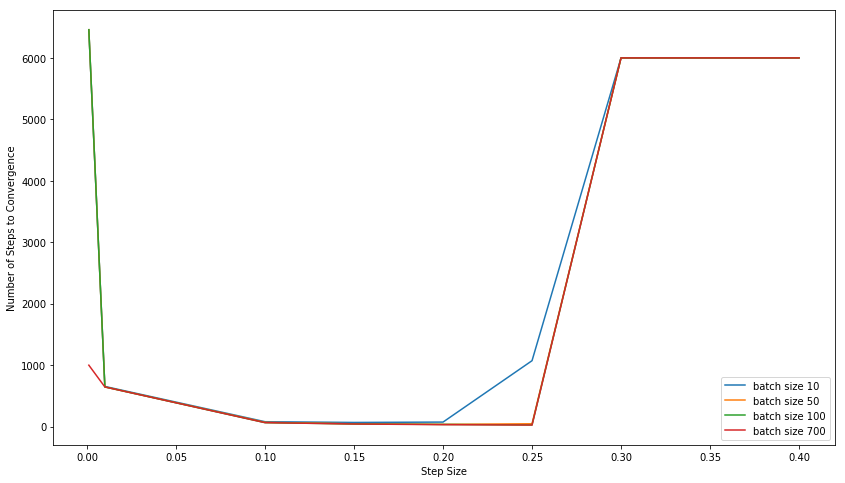

In [22]:
plt.figure(figsize=(14, 8))

# init iteration values
η_values = [0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.01, 0.001]
batch_values = [10, 50, 100, 700]
convergence_speed = []

# check η and batch size combinations
for i, batch_size in enumerate(batch_values):
    for η in η_values:
        num_steps = linear_regression_model_3(batch_size=batch_size, λ=1, η=η, convergence_condition=convergence_condition)[0]

        # accomodate for grafing the value of inf
        if num_steps == float('inf'):
            num_steps = 6000

        # append to output list
        if len(convergence_speed) <= i:
            convergence_speed.append([])
        convergence_speed[i].append(num_steps)

    # plot
    plt.plot(η_values, convergence_speed[i], label='batch size '+str(batch_size))
    print('batch size ', batch_size, ' complete')
    
plt.legend()
plt.xlabel('Step Size')
plt.ylabel('Number of Steps to Convergence')

In [23]:
# print out raw data
batch_η_dict = {}
for i, batch_size in enumerate(batch_values):
    batch_η_dict['batch size '+str(batch_size)] = convergence_speed[i]

pd.DataFrame(batch_η_dict, index=η_values)

,batch size 10,batch size 100,batch size 50,batch size 700
0.400,6000,6000,6000,6000
0.300,6000,6000,6000,6000
0.250,1073,27,47,26
0.200,74,36,37,32
0.150,68,44,46,43
0.100,80,65,70,65
0.010,654,646,646,646
0.001,6455,6459,6459,1000


As a general trend, the larger the batch, the faster the overall convergence rate in terms of number of gradient descent steps, mainly at low step sizes. This is because the more training points in your batch, the better the approximation of the overall gradient descent step. However this comes at a cost of computaional intensity for each individual gradient descent step, and at a cost of memory to hold the structures needed for the larger data set.

The largest batch size, $700$, is the best overall batch in terms of training time.

### 2.2.3

In [24]:
λ_values = [0, 0.0001, 0.001, 0.01, 0.1, 1]
convergence_conditions = []

# generate convergence conditions
for λ in λ_values:
    convergence_conditions.append(linear_regression_model_3(batch_size=700, λ=λ, η=0.1, convergence_condition=0)[1])

print('convergence conditions: ', convergence_conditions)

convergence conditions:  [0.034606677, 0.034632124, 0.034860507, 0.0373592, 0.055571161, 0.099237233]


0 : 0.0344443 0.0385494 0.0430177


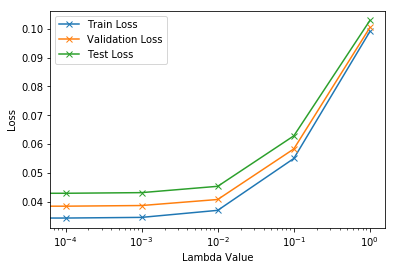

In [25]:
train_losses = []
valid_losses = []
test_losses = []

# evaluate λ values given the above convergence conditions
for i, λ in enumerate(λ_values):
    _, curr_train_loss, curr_valid_loss, curr_test_loss \
        = linear_regression_model_3(batch_size=50, λ=λ, η=0.1, convergence_condition=convergence_conditions[i])
    
    train_losses.append(curr_train_loss)
    valid_losses.append(curr_valid_loss)
    test_losses.append(curr_test_loss)
    
    
# print value for λ = 0 as it won't appear on the graph
print(λ_values[0], ':', train_losses[0], valid_losses[0], test_losses[0])

# plot
plt.plot(λ_values, train_losses, '-x', label='Train Loss')
plt.plot(λ_values, valid_losses, '-x', label='Validation Loss')
plt.plot(λ_values, test_losses, '-x', label='Test Loss')
plt.legend()
plt.xscale('log')
plt.xlabel('Lambda Value')
plt.ylabel('Loss')

As $\lambda$ increases, as do the train, test and validation losses. A second thing to note is that the difference between the training, validation and test sets decrease as $\lambda$ is increased. This is due to the penalty for overfitting test data. Though not shown on the graph because itis logarithmic, $\lambda = 0$ boasts the lowest loss.

We use the validation set to tune the hyperparameters because the validation set is used to tune hyperparameters to avoid weight overfitting on the training set, while test data is used to check how overfitted the model is overall (training data plus validation data).